In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
from dn_utils.behavioral_models_REF import *
from scipy import stats
import scipy.io

plt.style.use('ggplot')
%matplotlib inline

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/sourcedata/behavioral" 
beh, meta = load_behavioral_data(root=beh_path)
n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


### Is performance above chance level? Do task differ in performance?

In [3]:
# Included subjects
sub_idx_filtered = np.delete(np.arange(n_subjects), meta['dim1'].index('m19'))

won_bool_mean = np.mean(
    beh[sub_idx_filtered, :, :, meta['dim4'].index('won_bool')], axis=2
)
print('Overal mean correct choice rate:\n', np.mean(won_bool_mean)) 
print('Correct choice std:\n', np.std(won_bool_mean))

# H0: accuracy is at chance level
mean_chance = stats.ttest_1samp(np.mean(won_bool_mean, 1), popmean=0)
print(mean_chance)

# H0: no difference between conditions in accuracy
mean_difference = stats.ttest_rel(won_bool_mean[:, 0], won_bool_mean[:, 1])
print(mean_difference)

Overal mean correct choice rate:
 0.6252199413489736
Correct choice std:
 0.05808228644807999
Ttest_1sampResult(statistic=79.16320556995025, pvalue=2.141607241437138e-36)
Ttest_relResult(statistic=0.4574407651379915, pvalue=0.6506499576279976)


### Do reward magnitudes affect choice?
Test the correlation between:
1. the difference in reward magnitude for left and right side
2. averaged (across subjects and conditions) probability of choosing right side

In `response_probability` first column corresponds to all unique values of the difference in reward magnitude for left and right side and second column reflects proportion of right side choices for corresponding difference in reward magnitude.

In [4]:
magn_rl_diff = beh[sub_idx_filtered, :, :, meta['dim4'].index('magn_right')] \
             - beh[sub_idx_filtered, :, :, meta['dim4'].index('magn_left')] 
response = beh[sub_idx_filtered, :, :, meta['dim4'].index('response')]

diff_values = np.unique(magn_rl_diff)
response_probability = np.zeros((len(diff_values), 2))
response_probability[:, 0] = diff_values

for i, diff in enumerate(diff_values):
    diff_response = response[magn_rl_diff == diff]
    diff_response = diff_response[np.nonzero(diff_response)]
    response_probability[i, 1] = np.mean((diff_response + 1) / 2)
    
magn_rl_diff_stat = stats.pearsonr(response_probability[:, 0], response_probability[:, 1])
print('r = {:.2f}\np = {}'.format(magn_rl_diff_stat[0], magn_rl_diff_stat[1]))

r = 0.94
p = 6.383845402240476e-20


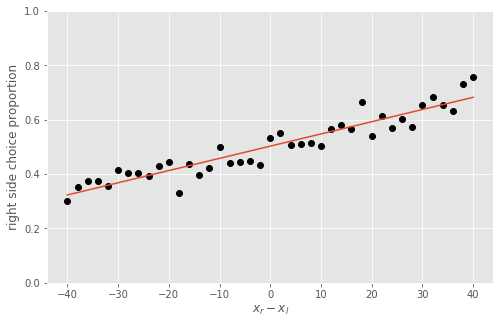

In [5]:
x = response_probability[:, 0]
y = response_probability[:, 1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), facecolor='w')
ax.plot(x, y, 'ko')
ax.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))

ax.set_xlabel('$x_r - x_l$')
ax.set_ylabel('right side choice proportion')
ax.set_ylim([0, 1])
plt.show()

### Is number of reversals related to esitimated parameters?
Test possible relationship between:
1. number of reversals (indicator of probability matching behavior) 
2. difference in estimaated learning rates for positive and negative PEs

In [6]:
# Number of reversals for each participant
def calculate_reversals(response):
    '''Calculate number of side switches in subject responses.'''
    return len(np.nonzero(np.diff(response[np.nonzero(response)]))[0])

reversals = np.zeros((n_subjects, n_conditions))

for i in range(n_subjects):
    for j in range(n_conditions):
        reversals[i, j] = calculate_reversals(
            beh[i, j, :, meta['dim4'].index('response')]
        )
        
# Estimated parameters
alpha_est = np.load('matjags-dn/data/subjects_point_estimates/alpha_pdci_mle.npy')
mat = scipy.io.loadmat('matjags-dn/data/vba_input/pmp_seq.mat', squeeze_me=True)

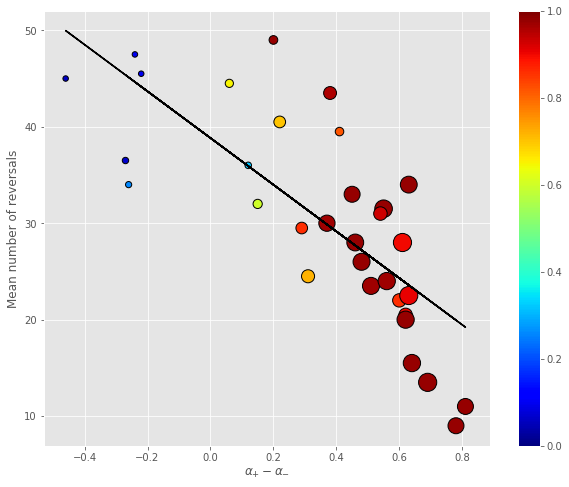

In [7]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w')

# Color indicates value alpha-, size indicates goodness-of-fit for the PDCI model
x = alpha_est[:,0] - alpha_est[:,1] 
y = np.mean(reversals, axis=1)
s = 300*(mat['pmp_seq'][2, :] / np.max(mat['pmp_seq'][2, :])) + 30
c = alpha_est[:, 0]

sc = ax.scatter(
    x, y, s=s, c=c,
    cmap='jet', vmin=0, vmax=1,
    linewidth=1, edgecolor='k',
)

plt.colorbar(sc)
ax.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), 'k')
ax.set_xlabel(r'$\alpha_{+} - \alpha_{-}$')
ax.set_ylabel('Mean number of reversals')
plt.show()

### What is the distribution of reaction time?

Reaction time distribution plotted for both conditions.

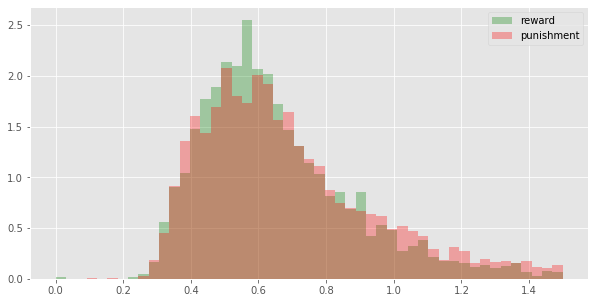

In [8]:
# Look at reaction time distribution for both conditions
fig, ax = plt.subplots(facecolor='w', figsize=(10, 5))

rt_rew = beh[:, 0, :, meta['dim4'].index('rt')].flatten()
rt_pun = beh[:, 1, :, meta['dim4'].index('rt')].flatten()

ax.hist(rt_rew, color='g', bins=np.linspace(0, 1.5, 50), alpha=.3, density=True, label='reward')
ax.hist(rt_pun, color='r', bins=np.linspace(0, 1.5, 50), alpha=.3, density=True, label='punishment');
ax.legend()
plt.show()